In [1]:
import os
os.chdir('/data3.5T/S312112030/DeepTTA')

print(os.getcwd())

/data3.5T/S312112030/DeepTTA


In [2]:
import argparse
# import shutil
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import  DataLoader, Subset
import torch.nn.init as init
from sklearn.model_selection import KFold
import copy
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import random
import gc
import os
import importlib.util

from utils.ESPF_drug2emb import drug2emb_encoder
from utils.Model import Omics_DrugESPF_Model
from utils.split_data_id import split_id,repeat_func
from utils.create_dataloader import OmicsDrugDataset
from utils.train import train, evaluation
from utils.correlation import correlation_func
from utils.plot import loss_curve, correlation_density,Density_Plot_of_AUC_Values
from utils.tools import get_data_value_range,set_seed,get_vram_usage
from utils.Metrics import MetricsCalculator

In [ ]:

# average the 8head attention score matrix
best_fold_best_epoch_attention_score_matrix = best_fold_best_epoch_attention_score_matrix.mean(dim=1)# torch.Size([bsz, 8, 50, 50])
# ==>[bsz, 50, 50]

In [3]:
device = (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))
print(f"Training on device {device}.")

Training on device cuda.


In [4]:
import torch.nn as nn
from utils.Loss import Custom_LossFunction
from utils.Custom_Activation_Function import ScaledSigmoid

test_dataset = False # True:small dataset, False: full dataset
test = False # batch_size = 3, num_epoch = 2

omics_files = {
    'Mut': "../data/CCLE/CCLE_match_TCGAgene_PRISMandEXPsample_binary_mutation_476_6009.txt",
    'Exp': "../data/CCLE/CCLE_exp_476samples_4692genes.txt",
    # Add more omics types and paths as needed
    }
omics_dict = {'Mut':0,'Exp':1,'CN':2, 'Eff':3, 'Dep':4, 'Met':5}
omics_data_dict = {}
omics_data_tensor_dict = {}
omics_numfeatures_dict = {}
omics_encode_dim_dict ={'Mut':[1000,100,50],'Exp':[1000,100,50], # Dr.Chiu:exp[500,200,50]
                        'CN':[100,50,30], 'Eff':[100,50,30], 'Dep':[100,50,30], 'Met':[100,50,30]}

TCGA_pretrain_weight_path_dict = {'Mut': "./results/Encoder_tcga_mut_1000_100_50_best_loss_0.0066.pt",
                                  'Exp': "./results/Encoder_tcga_exp_1000_100_50_best_loss_0.7.pt",
                                  # Add more omics types and paths as needed
                                }
seed = 42
#hyperparameter
model_name = "Omics_DrugESPF_Model"
AUCtransform = None #"-log2", None
splitType= 'byCCL' # byCCL byDrug
kfoldCV = 5
include_omics = ['Mut']
max_drug_len=50 # 不夠補零補到50 / 超過取前50個subwords(index) !!!!須改方法!!!!
drug_embedding_feature_size = 128
ESPF = False # False True
Transformer = False 
#需再修改-----------

intermediate_size =512
num_attention_heads = 8
attention_probs_dropout_prob = 0.1
hidden_dropout_prob = 0.1

if ESPF is True:
    
    drug_encode_dims =[1600,400,100] # 50*128
    dense_layer_dim = sum(omics_encode_dim_dict[omic_type][2] for omic_type in include_omics) + drug_encode_dims[2] # MLPDim
elif ESPF is False:
    
    drug_encode_dims =[110,55,22]
    dense_layer_dim = sum(omics_encode_dim_dict[omic_type][2] for omic_type in include_omics) + drug_encode_dims[2] # MLPDim
#需再修改-------------
    
activation_func = nn.ReLU()  # ReLU activation function # Leaky ReLu
activation_func_final = nn.Sigmoid() # ScaledSigmoid(scale=8) # GroundT range ( 0 ~ scale )
#nn.Sigmoid()or ReLU() or Linear/identity(when -log2AUC)
batch_size = 64
num_epoch = 200 # for k fold CV 
patience = 15
warmup_iters = 150
Decrease_percent = 0.99
continuous = True
learning_rate=1e-05
criterion = Custom_LossFunction(loss_type="MSE", loss_lambda=1.0, regular_type=None, regular_lambda=0.001) #nn.MSELoss()#
""" A customizable loss function class.
    Args:
        loss_type (str): The type of loss to use ("RMSE", "MSE", "MAE", "MAE+MSE", "MAE+RMSE").
        loss_lambda (float): The lambda weight for the additional loss (MSE or RMSE) if applicable. Default is MAE+ 1.0*(MSE or RMSE).
        regular_type (str): The type of regularization to use ("L1", "L2", "L1+L2"), or None for no regularization.
        regular_lambda (float): The lambda weight for regularization. Default is 0.001."""

hyperparameter_print = f' omics_dict ={omics_dict}\n omics_files ={omics_files}\n TCGA_pretrain_weight_path_dict ={TCGA_pretrain_weight_path_dict}\n seed ={seed}\n  model_name ={model_name}\n AUCtransform ={AUCtransform}\n splitType ={splitType}\n kfoldCV ={kfoldCV}\n omics_encode_dim ={[(omic_type,omics_encode_dim_dict[omic_type]) for omic_type in include_omics]}\n max_drug_len ={max_drug_len}\n drug_embedding_feature_size ={drug_embedding_feature_size}\n ESPF ={ESPF}\n Transformer ={Transformer}\n intermediate_size ={intermediate_size}\n num_attention_heads ={num_attention_heads}\n attention_probs_dropout_prob ={attention_probs_dropout_prob}\n hidden_dropout_prob ={hidden_dropout_prob}\n drug_encode_dims ={drug_encode_dims}\n dense_layer_dim = {dense_layer_dim}\n activation_func = {activation_func}\n activation_func_final = {activation_func_final}\n batch_size = {batch_size}\n num_epoch = {num_epoch}\n patience = {patience}\n warmup_iters = {warmup_iters}\n Decrease_percent = {Decrease_percent}\n continuous ={continuous}\n learning_rate = {learning_rate}\n criterion ={criterion}\n'

__translation_table__ = str.maketrans({
    "*": "",    "/": "",    ":": "-",    "%": "",
    "'": "",    "\"": "",    "[": "",    "]": "",
    ",": "" })

hyperparameter_folder_part = (f'Model{model_name}_{splitType}_Omics{[omic_type for omic_type in include_omics]}_ESPF{ESPF}_Tranformer{Transformer}').translate(__translation_table__)


In [5]:
# get specific cancer type sample omics data
set_seed(seed)
COAD_list = pd.read_csv("../data/CCLE/COAD,READ sample list.txt", sep='\t', index_col=0).index.tolist()
print(COAD_list)
for omic_type in include_omics:
    # Read the file
    omics_data_dict[omic_type] = pd.read_csv(omics_files[omic_type], sep='\t', index_col=0)
    omics_data_dict[omic_type] = omics_data_dict[omic_type].loc[COAD_list]
    print((omics_data_dict[omic_type]).shape ) 
    sample_mut_label = ((omics_data_dict[omic_type])['TP53'] == 1).astype(int).tolist()
    print(sample_mut_label)
    if test_dataset is True:
        # Specify the index as needed
        omics_data_dict[omic_type] = omics_data_dict[omic_type][:76]  # Adjust the row selection as needed
    if omic_type == "Exp":# apply Column-wise Min-Max Normalization 
        scaler = MinMaxScaler() 
        omics_data_dict[omic_type] = pd.DataFrame(scaler.fit_transform(omics_data_dict[omic_type]),index=omics_data_dict[omic_type].index,columns=omics_data_dict[omic_type].columns)
    
    omics_data_tensor_dict[omic_type]  = torch.tensor(omics_data_dict[omic_type].values, dtype=torch.float32).to(device)
    omics_numfeatures_dict[omic_type] = omics_data_tensor_dict[omic_type].shape[1]
    print(f"{omic_type} tensor shape:", omics_data_tensor_dict[omic_type].shape)
    print(f"{omic_type} num_features",omics_numfeatures_dict[omic_type])


['ACH-000007', 'ACH-000252', 'ACH-000296', 'ACH-000403', 'ACH-000467', 'ACH-000552', 'ACH-000651', 'ACH-000680', 'ACH-000842', 'ACH-000895', 'ACH-000926', 'ACH-000943', 'ACH-000950', 'ACH-000955', 'ACH-000957', 'ACH-000958', 'ACH-000959', 'ACH-000967', 'ACH-000970', 'ACH-000971', 'ACH-000982', 'ACH-000985', 'ACH-000991', 'ACH-000997']
(24, 6009)
[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1]
Mut tensor shape: torch.Size([24, 6009])
Mut num_features 6009


In [6]:
drug_df= pd.read_csv("../data/no_Imputation_PRISM_Repurposing_Secondary_Screen_data/MACCS(Secondary_Screen_treatment_info)_union_NOrepeat.csv", sep=',', index_col=0)
print("drug_df",drug_df.shape)

# get "5-fluorouracil" data
drug_df= drug_df[drug_df['name'] == "5-fluorouracil"]
print(drug_df)

AUC_df = pd.read_csv("../data/no_Imputation_PRISM_Repurposing_Secondary_Screen_data/Drug_sensitivity_AUC_(PRISM_Repurposing_Secondary_Screen)_subsetted_NOrepeat.csv", sep=',', index_col=0)
AUC_df = (AUC_df.loc[COAD_list])[['FLUOROURACIL (BRD:BRD-K24844714-001-24-5)']]

if AUCtransform == "-log2":
    AUC_df = -np.log2(AUC_df)
if AUCtransform == "-log10":
    AUC_df = -np.log10(AUC_df)
print("AUC_df",AUC_df)

drug_df (1440, 9)
                              BRD_ID            name  \
Name                                                   
FLUOROURACIL  BRD-K24844714-001-24-5  5-fluorouracil   

                                         moa      target disease.area  \
Name                                                                    
FLUOROURACIL  thymidylate synthase inhibitor  DPYD, TYMS     oncology   

                                                     indication     phase  \
Name                                                                        
FLUOROURACIL  colorectal cancer, breast cancer, pancreatic c...  Launched   

                             smiles  \
Name                                  
FLUOROURACIL  Fc1c[nH]c(=O)[nH]c1=O   

                                                   MACCS166bits  
Name                                                             
FLUOROURACIL  0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...  
AUC_df             FLUOROURACIL (BRD:BRD-K248

In [7]:
if ESPF is True:
    drug_smiles =drug_df["smiles"] # 
    drug_names =drug_df.index
    # 挑出重複的SMILES
    duplicate =  drug_smiles[drug_smiles.duplicated(keep=False)]
    #--------------------------------------------------------------------------------------------------------------------------
    #ESPF
    vocab_path = "./dataset/ESPF/drug_codes_chembl_freq_1500.txt" # token
    sub_csv = pd.read_csv("./dataset/ESPF/subword_units_map_chembl_freq_1500.csv")# token with frequency

    drug_encode = pd.Series(drug_smiles).apply(drug2emb_encoder, args=(vocab_path, sub_csv, max_drug_len))
    drug_features_tensor = torch.tensor(np.array(drug_encode.values.tolist()), dtype=torch.long)
else:
    drug_encode = drug_df["MACCS166bits"]
    drug_encode_list = [list(map(int, item.split(','))) for item in drug_encode.values]
    print("MACCS166bits_drug_encode_list type: ",type(drug_encode_list))
    # Convert your data to tensors if they're in numpy
    drug_features_tensor = torch.tensor(np.array(drug_encode_list), dtype=torch.long)
#--------------------------------------------------------------------------------------------------------------------------
num_ccl = list(omics_data_dict.values())[0].shape[0]
num_drug = drug_encode.shape[0]
print("num_ccl,num_drug: ",num_ccl,num_drug)


MACCS166bits_drug_encode_list type:  <class 'list'>
num_ccl,num_drug:  24 1


我應該先預測出全部的組合數值，輸出成一個matrix.csv。之後就可以依照特定藥或特定ccl(ACH-)去取出預測數值再做分析驗證

In [ ]:
# Convert your data to tensors if they're in numpy
response_matrix_tensor = torch.tensor(AUC_df.values, dtype=torch.float32)
id_test = list(range(24))
set_seed(seed)
dataset = OmicsDrugDataset(omics_data_tensor_dict, drug_features_tensor, response_matrix_tensor, splitType, include_omics)

test_dataset = Subset(dataset, id_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

whole_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

In [ ]:
if 'weighted' in criterion.loss_type :    
    # Set threshold based on the 90th percentile # 將高於threshold的AUC權重增加
    weighted_threshold = np.nanpercentile(AUC_df.values, 90)    
    total_samples = (~np.isnan(AUC_df.values)).sum().item()
    few_samples = (AUC_df.values > weighted_threshold).sum().item()
    more_samples = total_samples - few_samples
    few_weight = total_samples / (2 * few_samples)  
    more_weight = total_samples / (2 * more_samples)   
    # print("weighted_threshold",weighted_threshold)
    # print("total_samples",total_samples)
    # print("few_samples",few_samples)
    # print("more_samples",more_samples)
    # print("few_weight",few_weight)
    # print("more_weight",more_weight)
else:
    weighted_threshold = None
    few_weight = None
    more_weight = None



In [ ]:
%%time
# Evaluation
val_epoch_loss_list=[]
model = Omics_DrugESPF_Model(omics_encode_dim_dict, drug_encode_dims, activation_func, activation_func_final, dense_layer_dim, device,
                            drug_embedding_feature_size, intermediate_size, num_attention_heads , attention_probs_dropout_prob, hidden_dropout_prob, omics_numfeatures_dict, max_drug_len,
                            TCGA_pretrain_weight_path_dict= TCGA_pretrain_weight_path_dict).to(device=device)
best_weight = "./results/BestFold4_test_loss0.0071419_BestValEpo42_ModelOmics_DrugESPF_Model_byCCL_OmicsMut_ESPFFalse_TranformerFalse/BestValWeight.pt"
model.load_state_dict(torch.load(best_weight))

test_loss, test_targets, test_outputs, predAUCwithUnknownGT = evaluation(model, val_epoch_loss_list, criterion, test_loader, device,ESPF, Transformer, threshold, few_weight, more_weight, correlation='test')

State_dict for Sequential(
  (0): Linear(in_features=6009, out_features=1000, bias=True)
  (1): ReLU()
  (2): Linear(in_features=1000, out_features=100, bias=True)
  (3): Sigmoid()
  (4): Linear(in_features=100, out_features=50, bias=True)
) loaded successfully.

 MACCS166 is applied 

CPU times: user 248 ms, sys: 240 ms, total: 488 ms
Wall time: 508 ms


In [11]:
test_outputs

[array([0.81918496, 0.884012  , 0.8633232 , 0.864572  , 0.8617739 ,
        0.85899556, 0.8385467 , 0.8663893 , 0.8757676 , 0.8678688 ,
        0.853759  , 0.8604323 , 0.87391394], dtype=float32)]

In [13]:
sample_mut_label = ['TP53_Mut' if label == 1 else 'w/0 TP53_Mut' for label in sample_mut_label]

In [4]:
import torch
device = (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))
print(f"Training on device {device}.")
# Create a dictionary with tensors on GPU
gpu_dict = {
    "tensor1": torch.tensor([1, 2, 3]).to(device),
    "tensor2": torch.ones((2, 2)).to(device)
}

# Check where the tensors are stored
# print(gpu_dict.device)  # cuda:0
print(gpu_dict["tensor2"].device)  # cuda:0

Training on device cuda.
cuda:0


In [ ]:
import numpy as np
target = torch.tensor(np.array([0]))
target.numel()

0

In [7]:
((1+3+5)/3+(7+9)/2)/2


5.5

In [18]:
((1+3)/2+5+(7+9)/2)/3

5.0

In [19]:
((1+3+9)/3+(7+5)/2)/2

5.166666666666666

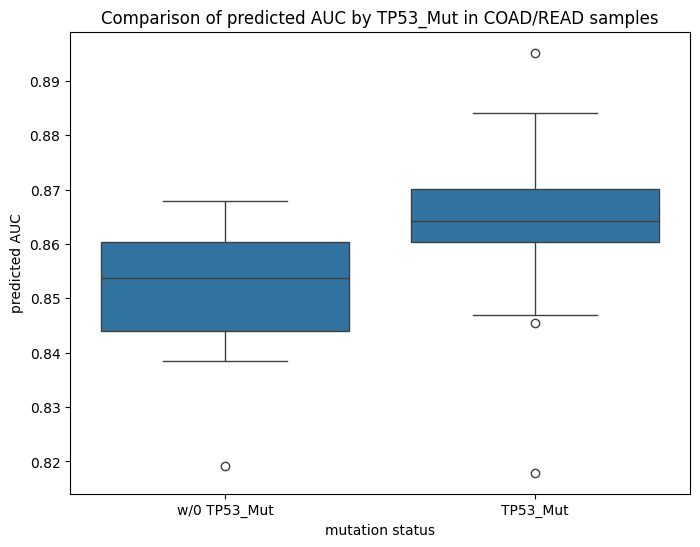

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Sample data (replace these with your actual lists)

# Create a DataFrame
df = pd.DataFrame({'predicted AUC': predAUCwithUnknownGT.cpu().reshape(-1) , 'mutation status': sample_mut_label})

# Create the boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(x='mutation status', y='predicted AUC', data=df)
plt.title('Comparison of predicted AUC by TP53_Mut in COAD/READ samples')
plt.show()

In [60]:
metrics_calculator = MetricsCalculator()
test_metrics= metrics_calculator.compute_all_metrics(np.concatenate(test_targets), np.concatenate(test_outputs),set_name='test_set')
metrics_calculator.print_results(set_name='test_set')

Evaluation test_set
{'Evaluation': 'test_set', 'RMSE': 0.060665064, 'MAE': 0.04174355, 'R^2': 0.031167805194854736}


In [64]:
# Correlation
id_unrepeat_test=[0]
test_pearson, test_spearman,test_AllSameValuesList_count  = correlation_func("byDrug", AUC_df.values,AUC_df.index,AUC_df.columns,id_unrepeat_test,test_targets,test_outputs)

transpose data_AUC_matrix to match split byDrug ((1, 24))


In [68]:
test_pearson

[0.7067521103747131]